<a href="https://colab.research.google.com/github/thecodecook/sk_parliamentary_speech_analysis/blob/main/Political_speech_analysis_political_views.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classified pariliament speaker's speech data analysis focused on their views

In [4]:
# @title Load classified speech data

import pandas as pd
import glob

!cp /content/drive/MyDrive/pariliament/poslanci-strana-klub.csv /content/poslanci-strana-klub.csv

# @markdown Which model's scores do we want to use?

gemini25f = True  # @param {type:"boolean"}
gpt41m = True  # @param {type:"boolean"}
claude35h = True  # @param {type:"boolean"}
deepseekv3 = True  # @param {type:"boolean"}

file_dict = {
    'gemini25f': ['politicians_classified_gemini_25_flash.csv', gemini25f],
    'gpt41m': ['politicians_classified_gpt_41_mini.csv', gpt41m],
    'claude35h': ['politicians_classified_claude_35_haiku.csv', claude35h],
    'deepseekv3': ['politicians_classified_deepseek.csv', deepseekv3]
}

dfs_with_llm = []

for llm, file_info in file_dict.items():
    if not file_info[1]:
      continue
    file_name = file_info[0]

    !cp /content/drive/MyDrive/pariliament/{file_name} /content/{file_name}
    temp_df = pd.read_csv(file_name)
    temp_df['llm'] = llm
    dfs_with_llm.append(temp_df)

df = pd.concat(dfs_with_llm).reset_index(drop=True)
df_poslanci = pd.read_csv('poslanci-strana-klub.csv')
df = pd.merge(df, df_poslanci, left_on='speaker', right_on='Meno a priezvisko', how='left')

display(df.head(2))
display(f"Rows: {df.shape[0]}")

,id,meeting_id,timestamp,speaker,speech_text,video_verified,video_start,video_stop,speech_length,num_tokens,sociocultural,geopolitical,corruption,llm,Meno a priezvisko,strana,klub
0,331592,9022,2024-10-29 09:48:00,Ján Hargaš,"Ďakujem za slovo, pán predsedajúci. No, toto b...",1,2970,4349,21882,7158,NaN,NaN,5.0,gemini25f,Ján Hargaš,PS,PS
1,331597,9022,2024-10-29 10:13:00,Marián Čaučík,"Ďakujem pekne, pán kolega, pán poslanec Hargaš...",1,4464,4465,1146,361,NaN,NaN,NaN,gemini25f,Marián Čaučík,KDH,KDH


'Rows: 59252'

### Visualize score means and distributions per llm

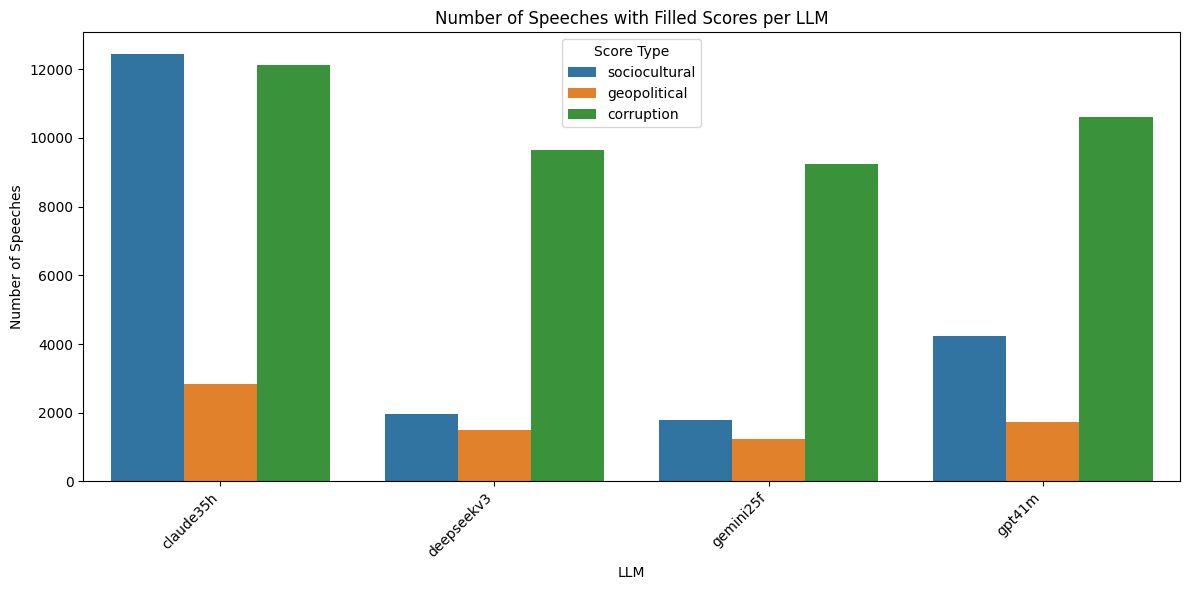

In [11]:
# @title Number of Speeches with Filled Scores per LLM

import matplotlib.pyplot as plt
import seaborn as sns

score_columns = ['sociocultural', 'geopolitical', 'corruption']

# Calculate the count of non-null values for each score column per LLM
score_counts = df.groupby('llm')[score_columns].count().reset_index()

# Melt the dataframe for easier plotting
score_counts_melted = score_counts.melt(id_vars='llm', var_name='score_type', value_name='count')

# Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=score_counts_melted, x='llm', y='count', hue='score_type')
plt.title('Number of Speeches with Filled Scores per LLM')
plt.xlabel('LLM')
plt.ylabel('Number of Speeches')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Score Type')
plt.tight_layout()
plt.show()

            sociocultural  geopolitical  corruption
llm                                                
claude35h       52.246848     37.929204   35.316832
deepseekv3      48.197348     37.007324   42.191582
gemini25f       37.518994     19.079248    9.013524
gpt41m          41.328365     18.884882   17.712047


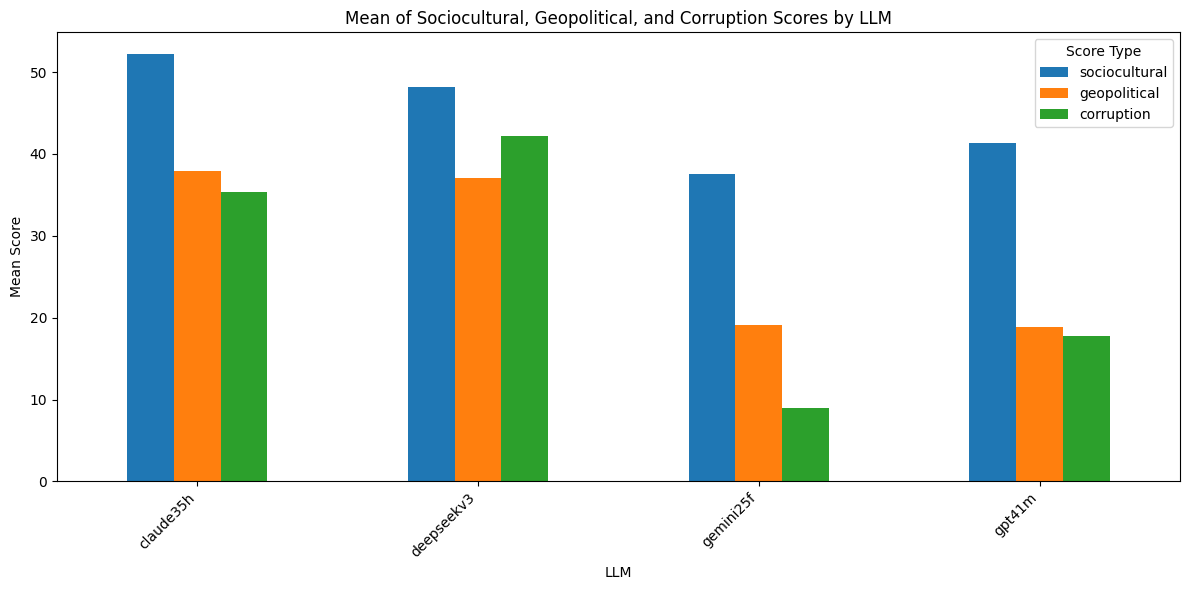

In [18]:
# @title Mean of Sociocultural, Geopolitical, and Corruption Scores by LLM

# Group by 'llm' and calculate the mean for the columns of interest
mean_by_llm = df.groupby('llm')[score_columns].mean()

# Print the mean values for each LLM
print(mean_by_llm)

# Optionally, you can also visualize the differences
import matplotlib.pyplot as plt

mean_by_llm.plot(kind='bar', figsize=(12, 6))
plt.title('Mean of Sociocultural, Geopolitical, and Corruption Scores by LLM')
plt.xlabel('LLM')
plt.ylabel('Mean Score')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Score Type')
plt.tight_layout()
plt.show()


<Figure size 2000x800 with 0 Axes>

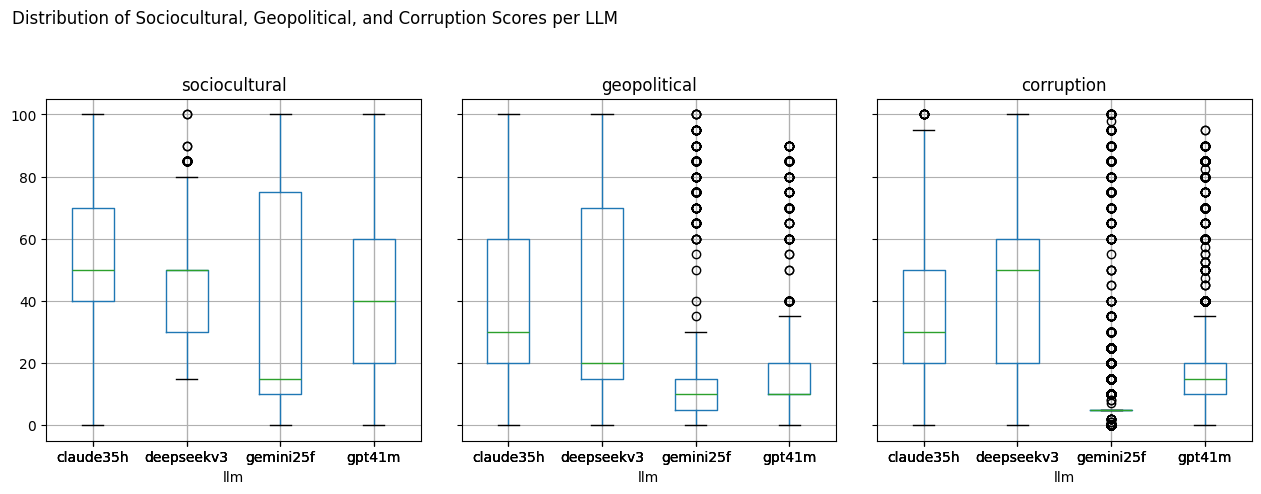

In [19]:
# @title Distribution of Sociocultural, Geopolitical, and Corruption Scores per LLM - boxplots

plt.figure(figsize=(20, 8)) # Increased the figure width
df.boxplot(column=score_columns, by='llm', layout=(1, len(score_columns)))
plt.suptitle('Distribution of Sociocultural, Geopolitical, and Corruption Scores per LLM', y=1.02)
plt.tight_layout(rect=[0, 0, 2, 0.98]) # Adjust layout to make room for the title
plt.show()


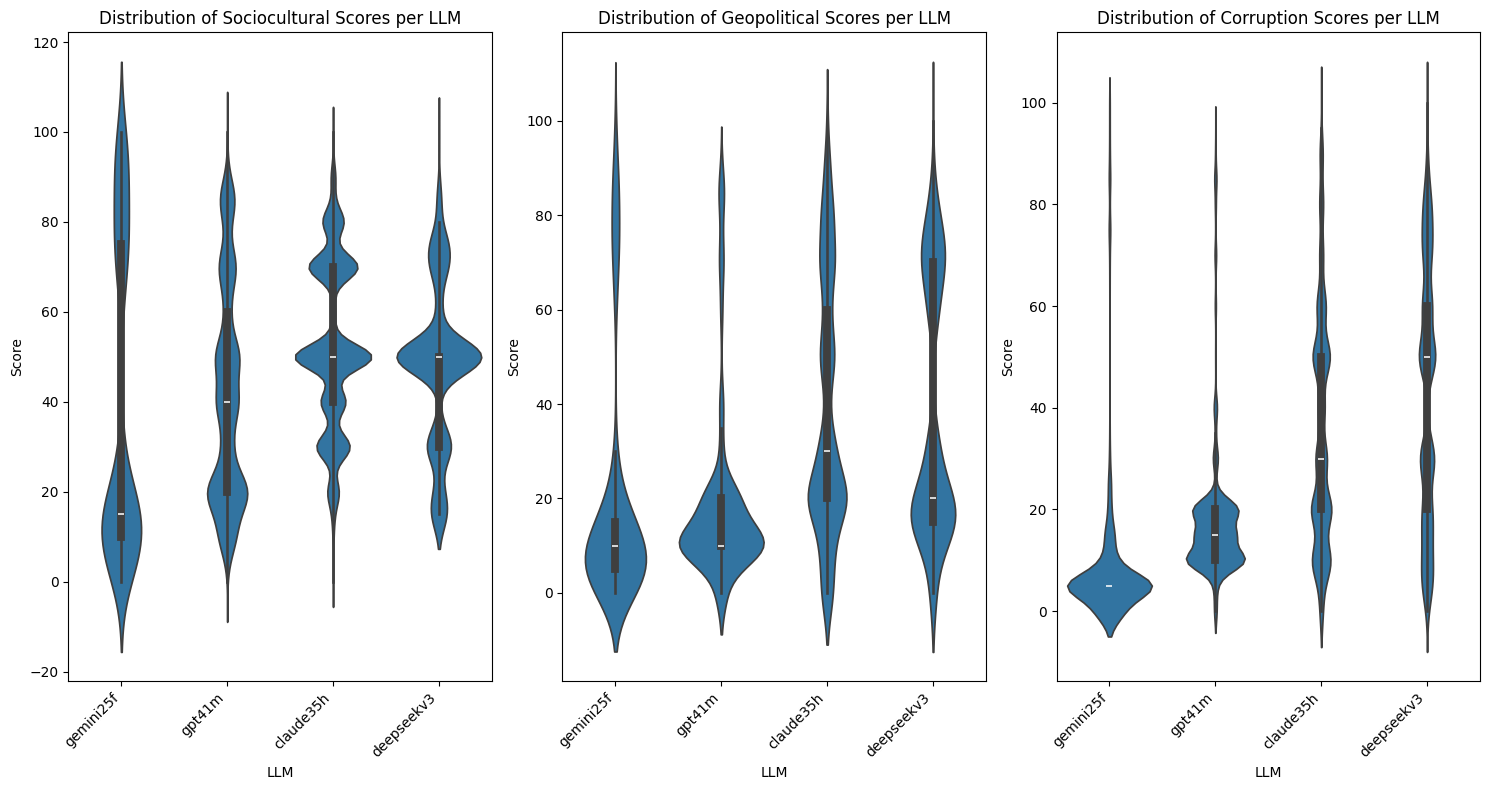

In [20]:
# @title Distribution of Sociocultural, Geopolitical, and Corruption Scores per LLM - violin

# Violin plots provide a richer view of the distribution shape
import seaborn as sns
plt.figure(figsize=(15, 8))
for i, col in enumerate(score_columns):
    plt.subplot(1, len(score_columns), i + 1)
    sns.violinplot(x='llm', y=col, data=df)
    plt.title(f'Distribution of {col.capitalize()} Scores per LLM')
    plt.xlabel('LLM')
    plt.ylabel('Score')
    plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## Political views analysis of speakers


In [22]:
# @title Prepare scored speeches, NaN for nonscored speeched

df_grouped_speeches = df.groupby('id').agg({
    'speaker': 'first',
    'speech_text': 'first',
    'strana': 'first',
    'klub': 'first',
    'sociocultural': 'mean',
    'geopolitical': 'mean',
    'corruption': 'mean',
}).reset_index()
df_grouped_speeches

,id,speaker,speech_text,strana,klub,sociocultural,geopolitical,corruption
0,296967,Roman Michelko,"Ďakujem za slovo. Myslím, že teraz bolo v jedn...",SNS,SNS,NaN,NaN,NaN
1,296969,Igor Matovič,"Aha, asi sa počujeme už, že? Dobre. Ja som si ...",OĽANO+KÚ+ZĽ,SLOVENSKO+KÚ+ZĽ,65.0,NaN,23.750000
2,296970,Marián Viskupič,"Pán predseda, ďakujem pekne za slovo. Zápisnic...",SaS,SaS,NaN,NaN,NaN
3,296971,Marián Viskupič,"Ďakujem pekne za slovo, pán predseda. Zápisnic...",SaS,SaS,NaN,NaN,NaN
4,296976,Marián Viskupič,"Pardon, musíme sa naučiť všetci. Teda zápisnic...",SaS,SaS,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
14829,342226,Július Jakab,"Vážené kolegyne, vážení kolegovia, ďakujem veľ...",OĽANO+KÚ+ZĽ,SLOVENSKO+KÚ+ZĽ,65.0,70.0,46.250000
14830,342227,Lucia Plaváková,"Ďakujem za reakcie, a teda v prvom rade mňa ti...",PS,PS,30.0,NaN,21.250000
14831,342229,Ondrej Dostál,"Vážené kolegyne, vážení kolegovia, úvodom by s...",SaS,SaS,70.0,NaN,28.750000
14832,342231,Beáta Jurík,"Ďakujem za slovo. Pán kolega Dostál, vy ste po...",PS,PS,30.0,17.5,18.333333


In [23]:
# @title Focus only on speakers with at least 5 speeches

speaker_counts = df_grouped_speeches.groupby('speaker')['speech_text'].count()
filtered_speakers = speaker_counts[speaker_counts >= 5].index
filtered_df = df_grouped_speeches[df_grouped_speeches['speaker'].isin(filtered_speakers)]
filtered_df


,id,speaker,speech_text,strana,klub,sociocultural,geopolitical,corruption
0,296967,Roman Michelko,"Ďakujem za slovo. Myslím, že teraz bolo v jedn...",SNS,SNS,NaN,NaN,NaN
1,296969,Igor Matovič,"Aha, asi sa počujeme už, že? Dobre. Ja som si ...",OĽANO+KÚ+ZĽ,SLOVENSKO+KÚ+ZĽ,65.0,NaN,23.750000
2,296970,Marián Viskupič,"Pán predseda, ďakujem pekne za slovo. Zápisnic...",SaS,SaS,NaN,NaN,NaN
3,296971,Marián Viskupič,"Ďakujem pekne za slovo, pán predseda. Zápisnic...",SaS,SaS,NaN,NaN,NaN
4,296976,Marián Viskupič,"Pardon, musíme sa naučiť všetci. Teda zápisnic...",SaS,SaS,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
14829,342226,Július Jakab,"Vážené kolegyne, vážení kolegovia, ďakujem veľ...",OĽANO+KÚ+ZĽ,SLOVENSKO+KÚ+ZĽ,65.0,70.0,46.250000
14830,342227,Lucia Plaváková,"Ďakujem za reakcie, a teda v prvom rade mňa ti...",PS,PS,30.0,NaN,21.250000
14831,342229,Ondrej Dostál,"Vážené kolegyne, vážení kolegovia, úvodom by s...",SaS,SaS,70.0,NaN,28.750000
14832,342231,Beáta Jurík,"Ďakujem za slovo. Pán kolega Dostál, vy ste po...",PS,PS,30.0,17.5,18.333333


In [24]:
# @title Filter out exmembers of parliament but keep ministers

ministers = [
    "Robert Fico",
    "Robert Kaliňák",
    "Denisa Saková",
    "Tomáš Taraba",
    "Peter Kmec",
    "Ladislav Kamenický",
    "Jozef Ráž",
    "Richard Takáč",
    "Samuel Migaľ",
    "Richard Raši",
    "Matúš Šutaj Eštok",
    "Boris Susko",
    "Juraj Blanár",
    "Erik Tomáš",
    "Tomáš Drucker",
    "Martina Šimkovičová",
    "Kamil Šaško",
    "Rudolf Huliak",
]

# Identify speakers in the ministers list
ministers_speakers = filtered_df[filtered_df['speaker'].isin(ministers)]

# Filter out rows where 'klub' is empty, but keep the rows for ministers
filtered_df = filtered_df[
    (filtered_df['klub'].notna()) |
    (filtered_df['speaker'].isin(ministers))
]

filtered_df


,id,speaker,speech_text,strana,klub,sociocultural,geopolitical,corruption
0,296967,Roman Michelko,"Ďakujem za slovo. Myslím, že teraz bolo v jedn...",SNS,SNS,NaN,NaN,NaN
1,296969,Igor Matovič,"Aha, asi sa počujeme už, že? Dobre. Ja som si ...",OĽANO+KÚ+ZĽ,SLOVENSKO+KÚ+ZĽ,65.0,NaN,23.750000
2,296970,Marián Viskupič,"Pán predseda, ďakujem pekne za slovo. Zápisnic...",SaS,SaS,NaN,NaN,NaN
3,296971,Marián Viskupič,"Ďakujem pekne za slovo, pán predseda. Zápisnic...",SaS,SaS,NaN,NaN,NaN
4,296976,Marián Viskupič,"Pardon, musíme sa naučiť všetci. Teda zápisnic...",SaS,SaS,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
14829,342226,Július Jakab,"Vážené kolegyne, vážení kolegovia, ďakujem veľ...",OĽANO+KÚ+ZĽ,SLOVENSKO+KÚ+ZĽ,65.0,70.0,46.250000
14830,342227,Lucia Plaváková,"Ďakujem za reakcie, a teda v prvom rade mňa ti...",PS,PS,30.0,NaN,21.250000
14831,342229,Ondrej Dostál,"Vážené kolegyne, vážení kolegovia, úvodom by s...",SaS,SaS,70.0,NaN,28.750000
14832,342231,Beáta Jurík,"Ďakujem za slovo. Pán kolega Dostál, vy ste po...",PS,PS,30.0,17.5,18.333333


In [32]:
# @title Average score by speaker with NA for low sample counts (Less than 3)

minimum_speeches = 3 #@param {type:"integer"}

# Group by speaker and compute the average scores
average_scores = filtered_df.groupby('speaker')[['sociocultural', 'geopolitical', 'corruption']].agg(['mean', 'count'])

# Function to replace mean with NA if count is less than 3
def replace_with_na(row, score_col):
    count_col = (score_col, 'count')
    if row[count_col] < minimum_speeches:
        return pd.NA
    else:
        return row[(score_col, 'mean')]

# Apply the function to each score column
for score_col in ['sociocultural', 'geopolitical', 'corruption']:
    average_scores[(score_col, 'mean')] = average_scores.apply(lambda row: replace_with_na(row, score_col), axis=1)

# Select only the 'mean' and 'count' columns
average_scores = average_scores[[('sociocultural', 'mean'), ('geopolitical', 'mean'), ('corruption', 'mean'),
                                 ('sociocultural', 'count'), ('geopolitical', 'count'), ('corruption', 'count')]]

# Flatten the MultiIndex columns and rename count columns
new_columns = []
for col in average_scores.columns:
    if col[1] == 'mean':
        new_columns.append(col[0])
    elif col[1] == 'count':
        new_columns.append(f'{col[0]}_count')

average_scores.columns = new_columns

average_scores

,sociocultural,geopolitical,corruption,sociocultural_count,geopolitical_count,corruption_count
speaker,,,,,,
Adam Lučanský,56.764706,<NA>,33.472222,17,1,12
Alena Nováková,50.0,<NA>,50.0,4,1,3
Alojz Hlina,60.533088,49.395833,35.768925,272,60,262
Andrea Turčanová,50.771605,15.416667,27.948718,81,10,78
Andrej Danko,61.25,61.75,47.083333,9,5,10
...,...,...,...,...,...,...
Ľubica Laššáková,51.136364,<NA>,43.823529,22,0,17
Ľubomír Galko,54.144737,29.801587,21.14629,133,42,137
Ľubomír Vážny,57.5,<NA>,38.75,8,0,11


In [70]:
# @title Let's focus on speakers with all scores defined

average_scores_no_nan = average_scores.dropna(subset=['sociocultural', 'geopolitical', 'corruption'])

average_scores_no_nan


,sociocultural,geopolitical,corruption,sociocultural_count,geopolitical_count,corruption_count
speaker,,,,,,
Alojz Hlina,60.533088,49.395833,35.768925,272,60,262
Andrea Turčanová,50.771605,15.416667,27.948718,81,10,78
Andrej Danko,61.25,61.75,47.083333,9,5,10
Anežka Škopová,37.5,24.267677,14.910338,79,33,79
Anna Záborská,66.121032,42.045455,26.938406,42,11,23
...,...,...,...,...,...,...
Zuzana Mesterová,46.450855,27.51938,22.447917,195,43,208
Zuzana Plevíková,70.814815,45.686275,51.130952,45,17,42
Zuzana Števulová,35.072144,15.544872,18.699176,283,78,273


In [41]:
# @title Setup color scheme and speakers with party for further analysis

def get_party_color(party):
    if party == 'PS':
        return '#00bcff'
    elif party == 'OĽANO+KÚ+ZĽ':
        return '#212429'
    elif party == 'HLAS – SD':
        return '#f90f18'
    elif party == 'SaS':
        return '#9dc21c'
    elif party == 'KDH':
        return '#0046a5'
    elif party == 'SMER – SD':
        return '#a71933'
    elif party == 'SNS':
        return '#964B00'
    else:
        return 'gray'

print("Party colors:")
print(f"PS: \033[48;2;0;188;255m  \033[0m #00bcff")
print(f"OĽANO+KÚ+ZĽ: \033[48;2;33;36;41m  \033[0m #212429")
print(f"HLAS – SD: \033[48;2;249;15;24m  \033[0m #f90f18")
print(f"SaS: \033[48;2;157;194;28m  \033[0m #9dc21c")
print(f"KDH: \033[48;2;0;70;165m  \033[0m #0046a5")
print(f"SMER – SD: \033[48;2;167;25;51m  \033[0m #a71933")
print(f"SNS: \033[48;2;150;75;0m  \033[0m #964B00")

# Merge and clean data
# Ensure that average_scores_no_nan includes the count columns
merged_df = pd.merge(average_scores_no_nan, df_poslanci, left_on='speaker', right_on='Meno a priezvisko', how='left')
merged_df.dropna(subset=['strana'], inplace=True)


Party colors:
PS:    #00bcff
OĽANO+KÚ+ZĽ:    #212429
HLAS – SD:    #f90f18
SaS:    #9dc21c
KDH:    #0046a5
SMER – SD:    #a71933
SNS:    #964B00


In [71]:
# @title 3D scatterplot of speaker's average scores

import plotly.graph_objects as go
import pandas as pd # Make sure pandas is imported

fig = go.Figure()
unique_parties = merged_df['strana'].unique()

for party in unique_parties:
    party_df = merged_df[merged_df['strana'] == party]
    color = get_party_color(party) # Assuming get_party_color is defined

    # Main marker trace
    fig.add_trace(go.Scatter3d(
        x=party_df['sociocultural'],
        y=party_df['geopolitical'],
        z=party_df['corruption'],
        mode='markers',
        name=party,
        marker=dict(size=4, color=color, opacity=0.8),
        hovertemplate=
            "<b>%{text}</b><br><br>" +
            "Sociokultúrna os: %{x} (%{customdata[0]})<br>" +  # Include sociocultural_count
            "Geopolitická os: %{y} (%{customdata[1]})<br>" +  # Include geopolitical_count
            "Korupcia: %{z} (%{customdata[2]})<br>" +      # Include corruption_count
            f"Strana: {party}<extra></extra>",
        text=party_df['Meno a priezvisko'],
        customdata=party_df[['sociocultural_count', 'geopolitical_count', 'corruption_count']], # Add count columns as customdata
        showlegend=True
    ))

    # Separate text trace for names
    fig.add_trace(go.Scatter3d(
        x=party_df['sociocultural'],
        y=party_df['geopolitical'],
        z=party_df['corruption'],
        mode='text',
        name=f"{party} - Mená",
        text=party_df['Meno a priezvisko'],
        textposition='top center',
        textfont=dict(size=9, color=color),
        showlegend=True,
        visible=True,
        hoverinfo='skip'
    ))

# Layout with customized legend
fig.update_layout(
    scene=dict(
        xaxis_title='Sociokultúrna os',
        yaxis_title='Geopolitická os ',
        zaxis_title='Korupcia'
    ),
    title='3D Scatter Plot of Speaker Scores colored by Party',
    height=800,
    legend=dict(
        title="Strana",
        itemsizing='constant',
        font=dict(size=10),
        itemwidth=30
    )
)

fig.show()

Centroid (Average Scores):
sociocultural    53.110707
geopolitical       34.6065
corruption       31.880262
dtype: object


<ipython-input-72-06980792e0b2>:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



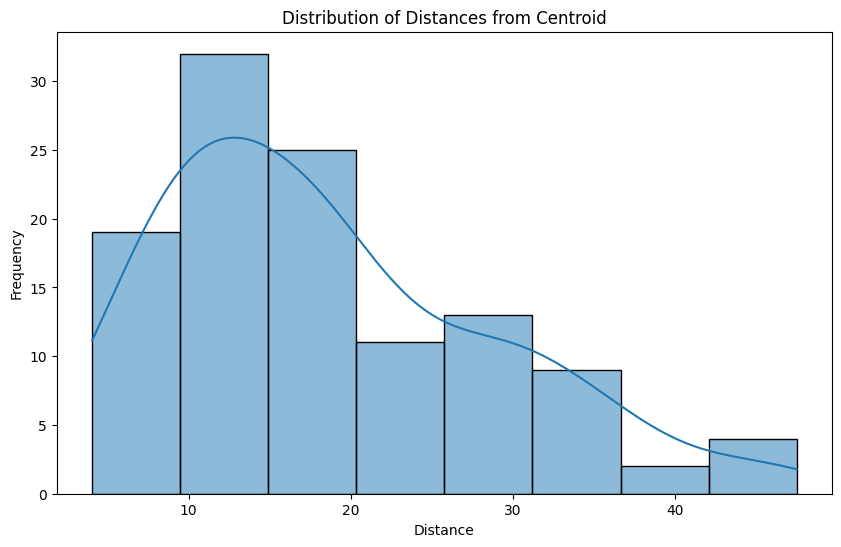


Descriptive Statistics for Distances from Centroid:
count    115.000000
mean      18.627038
std       10.153251
min        4.051957
25%       10.923343
50%       16.790061
75%       25.258342
max       47.509824
Name: distance_from_centroid, dtype: float64


In [72]:
# @title Distance from centroid

import numpy as np
from scipy.spatial import distance

# Calculate the centroid of the points
centroid = average_scores_no_nan[['sociocultural', 'geopolitical', 'corruption']].mean()
print("Centroid (Average Scores):")
print(centroid)

# Calculate the Euclidean distance of each point from the centroid
average_scores_no_nan['distance_from_centroid'] = average_scores_no_nan.apply(
    lambda row: distance.euclidean(row[['sociocultural', 'geopolitical', 'corruption']], centroid), axis=1
)

# Show the distribution of distances
plt.figure(figsize=(10, 6))
sns.histplot(average_scores_no_nan['distance_from_centroid'], kde=True)
plt.title('Distribution of Distances from Centroid')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.show()

# Optional: Print descriptive statistics for the distances
print("\nDescriptive Statistics for Distances from Centroid:")
print(average_scores_no_nan['distance_from_centroid'].describe())

In [73]:
# @title Outliers by Z-score dst from centroid

# Identify potential outliers using a common method like the IQR or Z-score
# Using Z-score: Points with a Z-score above a certain threshold (e.g., 2 or 3) are considered outliers.
# First, calculate the Z-score for the 'distance_from_centroid'
average_scores_no_nan['z_score_distance'] = (
    average_scores_no_nan['distance_from_centroid'] - average_scores_no_nan['distance_from_centroid'].mean()
) / average_scores_no_nan['distance_from_centroid'].std()

# Define a threshold for outlier identification (e.g., Z-score > 2)
outlier_threshold = 2.0 #@param {type:"number"}

# Filter for potential outliers
outliers_df = average_scores_no_nan[average_scores_no_nan['z_score_distance'] > outlier_threshold].copy()

# Merge with speaker names and party information for better context
outliers_with_info = pd.merge(outliers_df, df_poslanci, left_on='speaker', right_on='Meno a priezvisko', how='left')

# Select relevant columns for the output
outliers_output = outliers_with_info[['Meno a priezvisko', 'strana', 'distance_from_centroid', 'z_score_distance',
                                      'sociocultural', 'geopolitical', 'corruption',
                                      'sociocultural_count', 'geopolitical_count', 'corruption_count']]

# Sort by distance or Z-score to see the most extreme outliers first
outliers_output = outliers_output.sort_values(by='distance_from_centroid', ascending=False)

print("\nPotential Outliers (based on Z-score of distance from centroid > {}) and by how much:".format(outlier_threshold))
display(outliers_output)

# You can also visualize the outliers on the scatter plot by highlighting them.
# Let's create a new trace for the outliers in the 3D plot

# Add outlier trace to the existing figure 'fig'
outlier_color = 'black' # Define a color for outliers
outlier_size = 6      # Define a size for outlier markers

plt.figure(figsize=(10, 6))
plt.clf()

# Check if there are outliers before adding the trace
if not outliers_output.empty:
    fig.add_trace(go.Scatter3d(
        x=outliers_output['sociocultural'],
        y=outliers_output['geopolitical'],
        z=outliers_output['corruption'],
        mode='markers',
        name='Outliers',
        marker=dict(
            size=outlier_size,
            color=outlier_color,
            opacity=0.9,
            symbol='diamond' # Use a different symbol for outliers
        ),
         hovertemplate=
            "<b>%{text} (OUTLIER)</b><br><br>" +
            "Distance from Centroid: %{customdata[3]:.2f}<br>" +
            "Z-score of Distance: %{customdata[4]:.2f}<br>" +
            "Sociokultúrna os: %{x} (%{customdata[0]})<br>" +
            "Geopolitická os: %{y} (%{customdata[1]})<br>" +
            "Korupcia: %{z} (%{customdata[2]})<br>" +
            "Strana: %{customdata[5]}<extra></extra>",
        text=outliers_output['Meno a priezvisko'],
        customdata=outliers_output[['sociocultural_count', 'geopolitical_count', 'corruption_count',
                                    'distance_from_centroid', 'z_score_distance', 'strana']],
        showlegend=True
    ))

    # Optionally, add text labels for outliers directly on the plot
    fig.add_trace(go.Scatter3d(
        x=outliers_output['sociocultural'],
        y=outliers_output['geopolitical'],
        z=outliers_output['corruption'],
        mode='text',
        name='Outlier Names',
        text=outliers_output['Meno a priezvisko'],
        textposition='top center',
        textfont=dict(size=10, color=outlier_color),
        showlegend=False, # Don't show legend for text labels
        hoverinfo='skip',
        visible=True
    ))

# Update layout title to indicate outlier presence
fig.update_layout(title=f'3D Scatter Plot of Speaker Scores colored by Party (Outliers highlighted with Z-score > {outlier_threshold})')

fig.show()



Potential Outliers (based on Z-score of distance from centroid > 2.0) and by how much:


<ipython-input-73-a7cc27c78ee0>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Meno a priezvisko,strana,distance_from_centroid,z_score_distance,sociocultural,geopolitical,corruption,sociocultural_count,geopolitical_count,corruption_count
3,Rudolf Huliak,SNS,47.509824,2.844683,71.416667,74.166667,50.776515,25,3,22
0,Dagmar Kramplová,SNS,46.015048,2.697462,72.9,73.854167,45.496032,25,8,21
2,Robert Fico,SMER – SD,43.670032,2.466500,72.272135,67.916667,52.625,64,52,60
1,Pavel Ľupták,SNS,42.952161,2.395796,68.958333,70.972222,48.350694,30,12,24


<Figure size 1000x600 with 0 Axes>

In [66]:
average_scores_no_nan

,sociocultural,geopolitical,corruption,sociocultural_count,geopolitical_count,corruption_count,distance_from_centroid,z_score_distance,cluster
speaker,,,,,,,,,
Alojz Hlina,60.533088,49.395833,35.768925,272,60,262,16.998171,-0.160428,2
Andrea Turčanová,50.771605,15.416667,27.948718,81,10,78,19.727598,0.108395,1
Andrej Danko,61.25,61.75,47.083333,9,5,10,32.158219,1.332694,3
Anežka Škopová,37.5,24.267677,14.910338,79,33,79,25.269819,0.654252,1
Anna Záborská,66.121032,42.045455,26.938406,42,11,23,15.780638,-0.280344,2
...,...,...,...,...,...,...,...,...,...
Zuzana Mesterová,46.450855,27.51938,22.447917,195,43,208,13.548064,-0.500231,4
Zuzana Plevíková,70.814815,45.686275,51.130952,45,17,42,28.403977,0.962937,3
Zuzana Števulová,35.072144,15.544872,18.699176,283,78,273,29.367950,1.057879,1


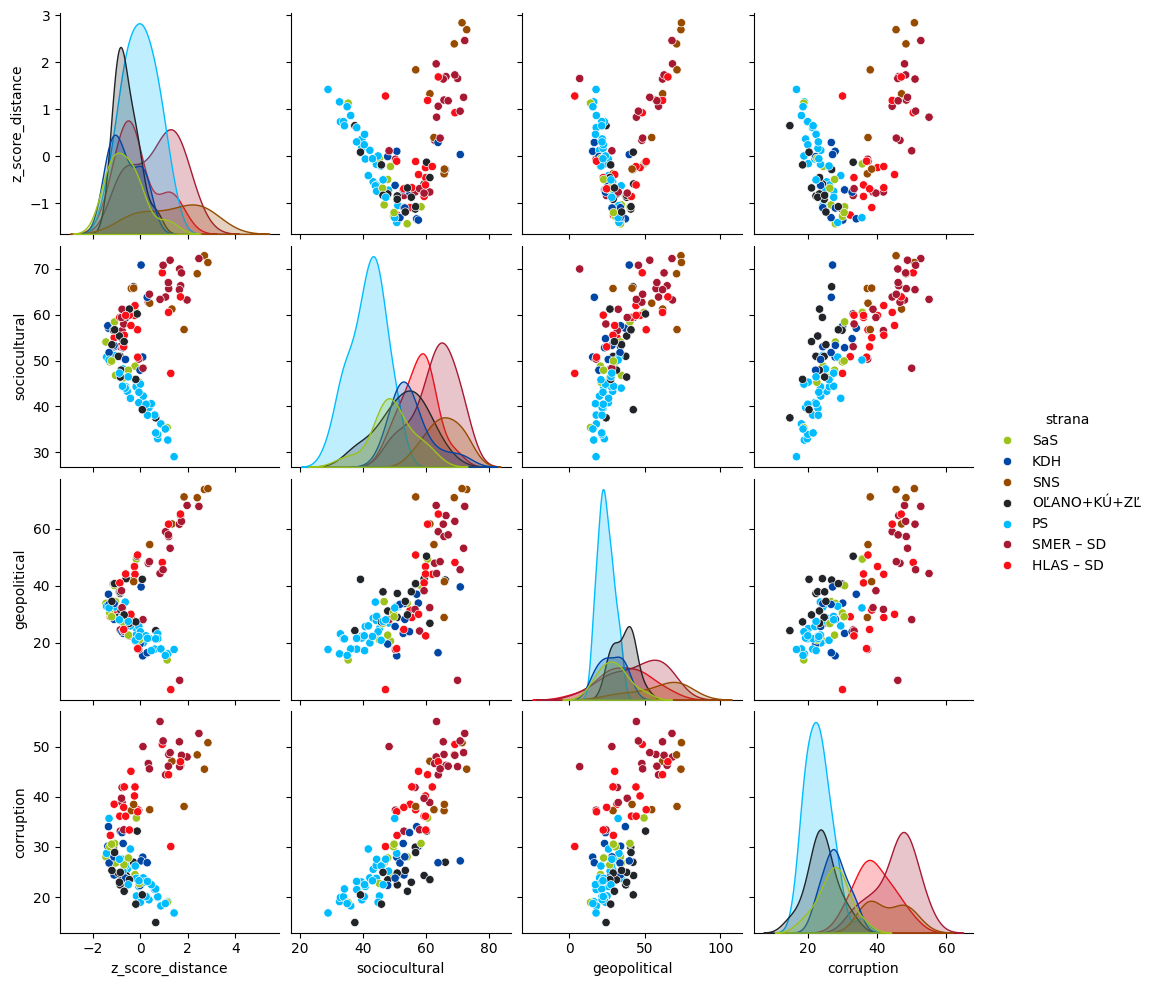

In [81]:
# @title 2D pair plot for scores and z-dst score

import seaborn as sns
import matplotlib.pyplot as plt

average_scores_no_nan_with_info = pd.merge(average_scores_no_nan, df_poslanci, left_on='speaker', right_on='Meno a priezvisko', how='left')
unique_parties = average_scores_no_nan_with_info['strana'].unique()

# Create a dictionary mapping party names to colors using the get_party_color function
party_colors = {party: get_party_color(party) for party in unique_parties}

# Create the 2D scatter plot matrix with custom colors
sns.pairplot(average_scores_no_nan_with_info, vars=[ 'z_score_distance', 'sociocultural', 'geopolitical', 'corruption'], hue='strana', palette=party_colors)
plt.show()

## Political views analysis of parties

In [45]:
# @title Compute party score

import pandas as pd

# Merge the dataframes to get the 'Strana' information
merged_df = pd.merge(average_scores, df_poslanci, left_on='speaker', right_on='Meno a priezvisko', how='left')

# Group by 'strana' and calculate the mean of each score
average_score_per_strana = merged_df.groupby('strana')[['sociocultural', 'geopolitical', 'corruption']].mean()

average_score_per_strana


,sociocultural,geopolitical,corruption
strana,,,
HLAS – SD,55.506497,36.878114,40.838288
KDH,55.331275,27.539757,27.912718
OĽANO+KÚ+ZĽ,52.634985,35.920326,24.092636
PS,41.56621,23.952599,23.185894
SMER – SD,62.87343,44.89425,44.430623
SNS,63.701801,59.605559,42.037312
SaS,49.366567,29.303733,27.465837


In [46]:
# @title 3D scatter plot for party scores

import plotly.graph_objects as go

# Ensure the index is CategoricalIndex
if not isinstance(average_score_per_strana.index, pd.CategoricalIndex):
    average_score_per_strana.index = pd.CategoricalIndex(average_score_per_strana.index)

# Map party names to colors
party_names = average_score_per_strana.index.categories
party_colors = [get_party_color(party) for party in party_names]  # You'll need to define this function

# Create a color mapping dictionary
color_map = dict(zip(party_names, party_colors))

# Apply colors to each point based on party
average_score_per_strana['color'] = average_score_per_strana.index.map(color_map)

# Create 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=average_score_per_strana['sociocultural'],
    y=average_score_per_strana['geopolitical'],
    z=average_score_per_strana['corruption'],
    mode='markers+text',
    text=average_score_per_strana.index,
    marker=dict(
        size=12,
        color=average_score_per_strana['color'],
        opacity=0.9
    ),
    textposition="top center",
)])

fig.update_layout(
    scene=dict(
        xaxis_title='Sociokultúrna os',
        yaxis_title='Geopolitická os',
        zaxis_title='Korupcia',
        #xaxis=dict(range=[0, 100]),
        #yaxis=dict(range=[0, 100]),
        #zaxis=dict(range=[0, 100]),
    ),
    title='Average Score per Political Party',
    height=800,
    legend_title="Strana"
)

fig.show()


## Clustering for fun

In [49]:
# @title Run clustering for n clusters

from sklearn.cluster import KMeans

n_clusters = 5 #@param {type:"integer"}

# Select the attributes for clustering
X = average_scores_no_nan[['sociocultural', 'geopolitical', 'corruption']]

# Create a KMeans model with 5 clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=0)

# Fit the model to the data
kmeans.fit(X)

# Add cluster labels to the DataFrame
average_scores_no_nan['cluster'] = kmeans.labels_

# Print the DataFrame with cluster labels
average_scores_no_nan


<ipython-input-49-f43c45bcf536>:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,sociocultural,geopolitical,corruption,sociocultural_count,geopolitical_count,corruption_count,distance_from_centroid,z_score_distance,cluster
speaker,,,,,,,,,
Alojz Hlina,60.533088,49.395833,35.768925,272,60,262,16.998171,-0.160428,2
Andrea Turčanová,50.771605,15.416667,27.948718,81,10,78,19.727598,0.108395,1
Andrej Danko,61.25,61.75,47.083333,9,5,10,32.158219,1.332694,3
Anežka Škopová,37.5,24.267677,14.910338,79,33,79,25.269819,0.654252,1
Anna Záborská,66.121032,42.045455,26.938406,42,11,23,15.780638,-0.280344,2
...,...,...,...,...,...,...,...,...,...
Zuzana Mesterová,46.450855,27.51938,22.447917,195,43,208,13.548064,-0.500231,4
Zuzana Plevíková,70.814815,45.686275,51.130952,45,17,42,28.403977,0.962937,3
Zuzana Števulová,35.072144,15.544872,18.699176,283,78,273,29.367950,1.057879,1


In [53]:
# @title 3D plot scatter plot for new party clusters

# Merge the dataframes to get the 'Strana' information
merged_df = pd.merge(average_scores_no_nan, df_poslanci, left_on='speaker', right_on='Meno a priezvisko', how='left')

# Create the 3D scatter plot with color based on 'cluster'
fig = go.Figure(data=[go.Scatter3d(
    x=merged_df['sociocultural'],
    y=merged_df['geopolitical'],
    z=merged_df['corruption'],
    mode='markers+text',
    text=merged_df['Meno a priezvisko'],  # Point name is now the speaker name
    marker=dict(size=4, color=merged_df['cluster'], showscale=True),
    textposition="top center",
    hovertemplate =
    "<b>%{text}</b><br><br>" +  # Speaker name in bold

    "Sociokultúrna os: %{x}<br>" +
    "Geopolitická os: %{y}<br>" +
    "Korupcia: %{z}<br>" +
    "Strana: %{customdata[0]}<br>" + # Party name in tooltip
    "Cluster: %{customdata[1]}<extra></extra>" # Cluster in tooltip
    , customdata=merged_df[['strana', 'cluster']] # Add party and cluster as customdata for hover
)])

fig.update_layout(
    scene=dict(
        xaxis_title='Sociokultúrna os',
        yaxis_title='Geopolitická os',
        zaxis_title='Korupcia',
    ),
    title='3D Scatter Plot of Speaker Scores colored by cluster',
    height=800
)

# Update the colorbar to show discrete colors and cluster labels
fig.update_traces(marker=dict(
    colorscale='Viridis',  # or any other categorical colorscale
    colorbar=dict(
        title='Cluster',
        tickvals=list(range(len(merged_df['cluster'].unique()))),
        ticktext=list(merged_df['cluster'].unique())
    )
))

fig.show()


In [61]:
# @title New Fico party

robert_fico_data = merged_df[merged_df['Meno a priezvisko'] == 'Robert Fico']

# Extract the cluster
if not robert_fico_data.empty:
  robert_fico_cluster = robert_fico_data['cluster'].iloc[0]
  print(f"Robert Fico is in cluster: {robert_fico_cluster}")

  fico_cluster_df = merged_df[merged_df['cluster'] == robert_fico_cluster]
  display(fico_cluster_df[['Meno a priezvisko', 'strana', 'klub']])
else:
  print("Robert Fico not found in the data.")


Robert Fico is in cluster: 3


,Meno a priezvisko,strana,klub
2,Andrej Danko,SNS,SNS
10,Dagmar Kramplová,SNS,SNS
14,Dušan Jarjabek,SMER – SD,SMER – SD
15,Dušan Muňko,SMER – SD,SNS
26,Ivan Hazucha,SMER – SD,SMER – SD
30,Jana Vaľová,SMER – SD,SMER – SD
42,Ján Richter,SMER – SD,SMER – SD
52,Marián Kéry,SMER – SD,SMER – SD
53,Marián Saloň,SMER – SD,SMER – SD
61,Michal Bartek,HLAS – SD,HLAS – SD
